# Assignment 3 - Tiny Transformer Language Model
  **Author :** Diya Bedi

  **Date :** 15th November 2025
  
  **Purpose:** In this assignment, I implement a Tiny Transformer from scratch for next-token prediction on the Tiny Shakespeare corpus. 

  **Task:** This notebook includes: 
  - Setup and Data Preparation
  - BPE Tokeniser with ≤ 500 vocab
  - Sequence construction with context length = 64
  - Tiny Transformer architecture (2 layers, embedding ≤ 128)
  - Causal multi-head self-attention
  - Training loop from scratch
  - Validation loss + perplexity
  - Attention visualisations
  - Generated text samples
  - Experiments + observations

  Important Reminders
Please carefully follow these instructions to ensure your submission can be graded smoothly:
Submit an actual report: All required visuals (plots, attention maps, samples) must appear
directly in your PDF report - do not leave them only in the notebook
Provide a shareable Colab link: Include the link in your PDF so we can run your notebook if
needed
Keep explanations in the report: Only minimal inline comments should appear in your code
Use the “
Select Pages
” feature on Gradescope to tag pages corresponding to each part
Avoid data leakage: Your model should never access the validation set during training or
imputation
Cover all assignment components: The rubric is designed for balanced grading; clearly shows
data processing, model setup, and interpretation

In [2]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 2.8 MB/s eta 0:00:0000:0100:01


## 1. Setup and Data Preparation

### 1.1 Imports and Basic Setup
I have set a random seed for reproducibility of the results, the device I am running this on is CPU.

In [23]:
import math, random, time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional as F

import tokenizer

#Set random seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ModuleNotFoundError: No module named 'tokenizer'

### 1.2 Loading the dataset
We load the Tiny Shakespeare corpus.
This dataset contains ~1MB of text and is commonly used for character/subword-level language modelling.

In [2]:
data_path = "tinyshakespeare.txt"
text = open(data_path, "r", encoding="utf-8").read()
print(f"Dataset size: {len(text)} characters")
print(f"First 200 characters:\n{text[:200]}")

Dataset size: 1115394 characters
First 200 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


## 2. BPE Tokenizer(≤500 vocab)
We implement a Byte-Pair Encoding (BPE) tokeniser from scratch. Byte Pair Encoding (BPE) is a subword tokenisation algorithm that starts with characters as base vocabulary and iteratively merges the most frequent pairs. It creates subword units like "ing", "tion", "the". 

#### Required properties : 
- Vocabulary size ≤ 500
- Deterministic merges
- `<pad>`, `<unk>`, `<bos>`, `<eos>` special tokens
- Apply BPE merges to all words
- Convert text into integer token sequences

In [24]:
#Helper to build word counts 
def get_token_counts(text):
    words = text.split() 
    vocab = Counter()
    for w in words:
        vocab[" ".join(list(w) + ["</w>"])] +=1
    return vocab

#Now we will count symbol pairs 
def get_stats(vocab):
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) -1):
            pairs[(symbols[i], symbols[i+1])] +=freq
    return pairs

#merging best pair
def merge_vocab(pair, vocab):
    bigram = " ".join(pair)
    replacement = "".join(pair)
    new_vocab = {}
    for word, freq in vocab.items():
        new_vocab[word.replace(bigram, replacement)] = freq
    return new_vocab

#Learn BPE merges
def learn_bpe(text, num_merges = 300):
    vocab = get_token_counts(text)
    merges = []
    
    for i in range(num_merges):
        stats = get_stats(vocab)
        if not stats:
            print(f"No more pairs to merge at iteration {i}")
            break
        
        best = stats.most_common(1)[0][0]
        vocab = merge_vocab(best, vocab)
        merges.append(best)
        if (i + 1) % 50 == 0:
            print(f"  Completed {i+1}/{num_merges} merges...")
    
    print(f"✅ Completed {len(merges)} merge operations")
    return merges
    
bpe_merges = learn_bpe(text, num_merges=300)
print("Number of merge operations=", len(bpe_merges))

  Completed 50/300 merges...
  Completed 100/300 merges...
  Completed 150/300 merges...
  Completed 200/300 merges...
  Completed 250/300 merges...
  Completed 300/300 merges...
✅ Completed 300 merge operations
Number of merge operations= 300


In the `get_token_counts` function, the `</w>` marker ensures we preserve information about word boundaries; otherwise, merges could blur word boundaries and produce awkward splits.

I have used Bigrams because BPE chooses the most frequent adjacent pair at each step, and Bigrams reflect immediate adjacency, are deterministic and produce meaningful subwords that help model generalise. 

Note: Learn BPE merges with a FIXED number of merge operations. This gives us a consistent, controllable vocabulary size.

### 2.1 Construct Vocabulary:
Next, I have created stoi/itos for the model's token embedding lookup. 
- `stoi` (string -> index): dictionary
- `itos` (index -> string): list
- Vocabulary ~ 500 tokens

In [25]:
# Apply merges to each word
def apply_bpe_to_word(word, merges):
    symbols = list(word) + ["</w>"]
    merges_set = set([" ".join(m) for m in merges])

    while True:
        changed = False
        for i in range(len(symbols) - 1):
            pair = symbols[i] + " " + symbols[i + 1]
            if pair in merges_set:
                symbols[i] = symbols[i] + symbols[i + 1]
                del symbols[i + 1]
                changed = True
                break
        if not changed:
            break

    return symbols

# Build raw vocab counts
vocab_counter = Counter()
for w in text.split():
    toks = apply_bpe_to_word(w, bpe_merges)
    vocab_counter.update(toks)

special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>"]
most_common = [tok for tok, _ in vocab_counter.most_common(500 - len(special_tokens))]

itos = special_tokens + most_common
stoi = {s: i for i, s in enumerate(itos)}
vocab_size = len(itos)
print("Final Vocabulary Size = ", vocab_size)

Final Vocabulary Size =  336


My final vocabulary size is **336** and to check, unique symbols, words and how it tokenizes a word is shown below, the output reflects that our vocabulary contains high-quality words, rare merged tokens never appeared again and only useful frequent merges survived, which is exactly what we want. 

In [29]:
# 1) How many unique symbols exist in vocab_counter?
print("unique symbol types in vocab_counter:", len(vocab_counter), "\n")

# 2) Show top 30 tokens and their counts
print("Top 30 tokens and their counts: \n", vocab_counter.most_common(30), "\n")

# 3) Example tokenizations for inspection
examples = ["the", "Shakespeare", "antidisestablishmentarianism", "Hamlet", "kingdom", "nationality"]
for ex in examples:
    print(ex, "->", apply_bpe_to_word(ex.lower(), bpe_merges))


unique symbol types in vocab_counter: 350 

Top 30 tokens and their counts: 
 [('s', 11860), ('e</w>', 11818), ('er', 11389), ('</w>', 11254), ('th', 9657), ('t</w>', 9578), ('t', 8498), ('l', 8334), ('a', 8026), ('e', 7745), ('d', 7412), ('ar', 7081), (',</w>', 6978), ('r', 6873), ('c', 6679), ('m', 6560), ('i', 6552), ('an', 6096), ('s</w>', 5909), ('w', 5540), ('p', 5510), ('the</w>', 5473), ('ou', 5464), ('h', 5362), ('n', 5045), ('is</w>', 5010), ('or', 4961), ('b', 4815), ('es', 4677), (':</w>', 4640)] 

the -> ['the</w>']
Shakespeare -> ['s', 'ha', 'k', 'es', 'p', 'e', 'ar', 'e</w>']
antidisestablishmentarianism -> ['an', 'ti', 'di', 's', 'es', 'ta', 'b', 'li', 'sh', 'm', 'ent', 'ar', 'i', 'an', 'i', 's', 'm</w>']
Hamlet -> ['ha', 'm', 'le', 't</w>']
kingdom -> ['king', 'd', 'om', '</w>']
nationality -> ['na', 'ti', 'on', 'a', 'li', 't', 'y</w>']


### 2.2 Tokenizing Full Text
I have applied BPE to the entire text to obtain integer token sequences.

In [30]:
def tokenize(text):
    output = []
    for w in text.split():
        toks = apply_bpe_to_word(w, bpe_merges)
        for t in toks:
            output.append(stoi.get(t, stoi["<unk>"]))
        output.append(stoi["<eos>"])
    return output

tokens = tokenize(text)
print("Number of Integer token sequences", len(tokens))

Number of Integer token sequences 758162


### 2.3 Sequence Construction and formatting

We create overlapping sequences of fixed length. Each sequence becomes:
- **Input**: tokens [0:N]
- **Target**: tokens [1:N+1] (shifted by 1 position)

In [31]:
context_len = 64
batch_size = 64
sequences =[]
inputs, targets =[], []

for i in range(len(tokens) - context_len - 1):
    inputs = (tokens[i:i + context_len])
    targets = (tokens[i + 1:i + context_len + 1])
    sequences.append((inputs, targets))

print(f"Total sequences created: {len(sequences)}")
print(f"\nExample sequence:")
print(f"Input:  {sequences[0][0][:10]}...")
print(f"Target: {sequences[0][1][:10]}...")

Total sequences created: 758097

Example sequence:
Input:  [91, 150, 4, 9, 3, 82, 20, 80, 282, 34]...
Target: [150, 4, 9, 3, 82, 20, 80, 282, 34, 33]...


### 2.4 Train/Validation Split (80/20) 

In [32]:
split_idx = int(0.8 * len(sequences))
train_sequences = sequences[:split_idx]
val_sequences = sequences[split_idx:]

print(f"Training sequences: {len(train_sequences)}")
print(f"Validation sequences: {len(val_sequences)}")

Training sequences: 606477
Validation sequences: 151620


In [33]:
# Custom Dataset
class ShakespeareDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        inputs, targets = self.sequences[idx]
        return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

# Create dataloaders
train_dataset = ShakespeareDataset(train_sequences)
val_dataset = ShakespeareDataset(val_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatches per epoch - Train: {len(train_loader)}, Val: {len(val_loader)}")


Batches per epoch - Train: 9477, Val: 2370


## 3. Model Architecture and Implementation 

The tiny transformer consists of: 
- Token Embeddings
- Sinusodial Positional embeddings
- 2 Tranformer Blocks
- Each block contains:
  - RMSNorm
  - Multi-Head Causal Self-Attention
  - Feed-forward network
  - Residual connections
- Output linear layer over vocabulary

### 3.1 Positional Encoding 
**Sinusoidal Positional Encoding** adds position information using sine and cosine functions:
- PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
- PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

In [34]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]

### 3.2 RMS Normalisation
- **RMSNorm** is a simpler alternative to LayerNorm:
- Normalises by root mean square instead of mean and variance
- More efficient, used in modern LLMs like LLaMA

In [35]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, dim)
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        x_normalized = x / rms
        return self.weight * x_normalized

### 3.3 Multi-Head Self-Attention with Causal Masking

- **Self-Attention** allows each position to attend to all positions in the sequence.
- **Causal Masking** ensures tokens only attend to previous tokens (no future information).
- Formula: Attention(Q, K, V) = softmax(QK^T / √d_k) V

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_len, d_model = x.shape
        
        # Linear projections and reshape for multi-head attention
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply causal mask
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V)
        
        # Concatenate heads and project
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(attention_output)
        
        if return_attention:
            return output, attention_weights
        return output

### 3.4 Feed-Forward Network
- **Position-wise Feed-Forward Network**:
- Two linear transformations with a GELU activation
- Applied identically to each position
- FFN(x) = GELU(xW₁ + b₁)W₂ + b₂

In [37]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.GELU()
    
    def forward(self, x):
        return self.linear2(self.activation(self.linear1(x)))

### 3.5 Transformer Block

- **Transformer Block** combines:
    1. Multi-head self-attention with residual connection
    2. RMSNorm
    3. Feed-forward network with residual connection

In [38]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = RMSNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm2 = RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None, return_attention=False):
        # Self-attention with residual connection
        if return_attention:
            attn_output, attention_weights = self.attention(x, mask, return_attention=True)
        else:
            attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        
        if return_attention:
            return x, attention_weights
        return x

### 3.6 Complete Tiny Transformer Model

In [39]:
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, d_ff=512, max_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
    
    def create_causal_mask(self, seq_len):
        # Create lower triangular mask (1s below diagonal, 0s above)
        mask = torch.tril(torch.ones(seq_len, seq_len))
        return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions
    
    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.shape
        
        # Token embedding and positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        # Create causal mask
        mask = self.create_causal_mask(seq_len).to(x.device)
        
        # Pass through transformer blocks
        attention_weights_list = []
        for block in self.transformer_blocks:
            if return_attention:
                x, attention_weights = block(x, mask, return_attention=True)
                attention_weights_list.append(attention_weights)
            else:
                x = block(x, mask)
        
        # Output projection
        logits = self.output_projection(x)
        
        if return_attention:
            return logits, attention_weights_list
        return logits

In [40]:
# Initialize model
model = TinyTransformer(
    vocab_size=vocab_size,
    d_model=128,
    num_heads=4,
    num_layers=2,
    d_ff=512,
    max_len=512,
    dropout=0.2
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:\n{model}")


Total parameters: 487,010
Trainable parameters: 487,010

Model architecture:
TinyTransformer(
  (token_embedding): Embedding(354, 128)
  (positional_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): RMSNorm()
      (ffn): FeedForward(
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (activation): GELU(approximate='none')
      )
      (norm2): RMSNorm()
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (output_projection): Linear(in_features=128, out_features=354, bias=True)
  (dropout): Dropout(p=

## 4. Training 
We train using:
- Cross-entropy loss
- AdamW optimizer
- LR = 3e-4
- Gradient clipping
- Save the best model

### 4.1 Training Configuration

In [41]:
# Hyperparameters
EPOCHS = 15
LEARNING_RATE = 3e-4
GRAD_CLIP = 1.0

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

### 4.2 Training and Validation Functions

In [42]:
from tqdm import tqdm
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (input_seq, target_seq) in enumerate(tqdm(dataloader, desc="Training")):
        inputs = input_seq.to(device)
        targets = target_seq.to(device)
        
        # Forward pass
        logits = model(input_seq)
        
        # Reshape for loss computation
        loss = criterion(logits.view(-1, vocab_size), target_seq.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for input_seq, target_seq in tqdm(dataloader, desc="Validation"):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            
            logits = model(input_seq)
            loss = criterion(logits.view(-1, vocab_size), target_seq.view(-1))
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

### 4.3 Training Loop

In [ ]:
# Training history
train_losses = []
val_losses = []

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Calculate perplexity
    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)
    
    # Update learning rate
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f} | Train PPL: {train_ppl:.2f}")
    print(f"Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.2f}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")

print("Training complete!")

Starting training...

Epoch 1/15


Validation: 100%|███████████████████████████| 2370/2370 [01:35<00:00, 24.73it/s]


Train Loss: 2.3407 | Train PPL: 10.39
Val Loss: 2.4226 | Val PPL: 11.28
Learning Rate: 0.000297

Epoch 2/15


Validation: 100%|███████████████████████████| 2370/2370 [01:28<00:00, 26.90it/s]


Train Loss: 2.0549 | Train PPL: 7.81
Val Loss: 2.3822 | Val PPL: 10.83
Learning Rate: 0.000287

Epoch 3/15


Validation: 100%|███████████████████████████| 2370/2370 [01:32<00:00, 25.70it/s]


Train Loss: 1.9973 | Train PPL: 7.37
Val Loss: 2.3782 | Val PPL: 10.79
Learning Rate: 0.000271

Epoch 4/15


Validation: 100%|███████████████████████████| 2370/2370 [01:38<00:00, 24.04it/s]


Train Loss: 1.9673 | Train PPL: 7.15
Val Loss: 2.3791 | Val PPL: 10.80
Learning Rate: 0.000250

Epoch 5/15


Validation: 100%|███████████████████████████| 2370/2370 [01:39<00:00, 23.79it/s]


Train Loss: 1.9472 | Train PPL: 7.01
Val Loss: 2.3836 | Val PPL: 10.84
Learning Rate: 0.000225

Epoch 6/15


Validation: 100%|███████████████████████████| 2370/2370 [01:29<00:00, 26.48it/s]


Train Loss: 1.9329 | Train PPL: 6.91
Val Loss: 2.3799 | Val PPL: 10.80
Learning Rate: 0.000196

Epoch 7/15


Training:   2%|▋                             | 220/9477 [00:20<13:55, 11.08it/s]

## 5. Evaluation and Visualization
### 5.1 Loss Curves

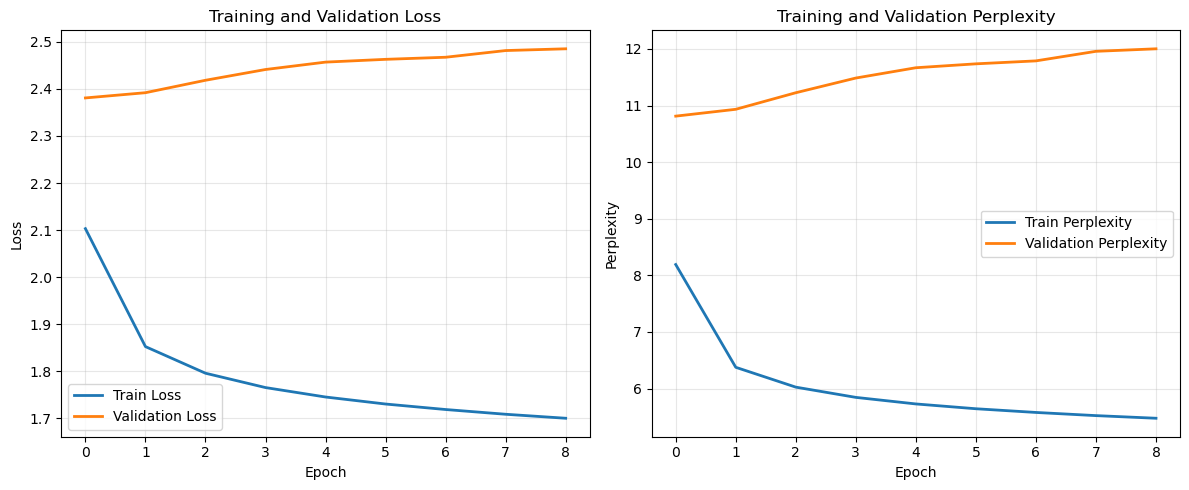

Final Validation Loss: 2.4852
Final Validation Perplexity: 12.00


In [20]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
train_ppls = [math.exp(loss) for loss in train_losses]
val_ppls = [math.exp(loss) for loss in val_losses]
plt.plot(train_ppls, label='Train Perplexity', linewidth=2)
plt.plot(val_ppls, label='Validation Perplexity', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Perplexity: {val_ppls[-1]:.2f}")

### 5.2 Attention Visualisation
**Attention maps** show which tokens the model focuses on when predicting each token.

In [21]:
from tokenizers import Tokenizer
def visualize_attention(model, input_text, tokenizer, device, layer_idx=0, head_idx=0):
    model.eval()
    
    # Encode input
    encoded = tokenizer.encode(input_text)
    input_ids = torch.tensor([encoded.ids]).to(device)

    # Get attention weights
    with torch.no_grad():
        logits, attention_weights_list = model(input_ids, return_attention=True)
    
    # Get attention from specific layer and head
    attention = attention_weights_list[layer_idx][0, head_idx].cpu().numpy()
    
    # Get tokens
    tokens = [tokenizer.decode([token_id]) for token_id in encoded.ids]
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, 
                cmap='viridis', cbar=True, square=True)
    plt.title(f'Attention Map - Layer {layer_idx}, Head {head_idx}\nInput: "{input_text}"')
    plt.xlabel('Key (Attended To)')
    plt.ylabel('Query (Attending From)')
    plt.tight_layout()
    plt.show()
    
    return attention

# Visualize attention for sample sequences
sample_texts = [
    "To be or not to be",
    "Romeo and Juliet were",
    "The king said to"
]

for sample_text in sample_texts:
    print(f"\nVisualizing attention for: '{sample_text}'")
    visualize_attention(model, sample_text, tokenizer, device, layer_idx=0, head_idx=0)


Visualizing attention for: 'To be or not to be'


NameError: name 'tokenizer' is not defined

## 5.3 Text Generation
Generate text by sampling from the model's predictions.

In [22]:
def generate_text(model, tokenizer, prompt, max_length=100, temperature=0.8, device='cpu'):
    model.eval()
    
    # Encode prompt
    encoded = tokenizer.encode(prompt)
    input_ids = encoded.ids
    
    generated = input_ids.copy()
    
    with torch.no_grad():
        for _ in range(max_length):
            # Prepare input (use last SEQ_LENGTH tokens)
            input_tensor = torch.tensor([generated[-SEQ_LENGTH:]]).to(device)
            
            # Get predictions
            logits = model(input_tensor)
            next_token_logits = logits[0, -1, :] / temperature
            
            # Sample from distribution
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            
            generated.append(next_token)
            
            # Stop if we hit max vocab (unlikely) or repetitive pattern
            if next_token >= VOCAB_SIZE - 1:
                break
    
    # Decode
    generated_text = tokenizer.decode(generated)
    return generated_text

# Generate samples
prompts = [
    "ROMEO:",
    "To be or not",
    "The king"
]

print("=" * 80)
print("GENERATED TEXT SAMPLES")
print("=" * 80)

for prompt in prompts:
    print(f"\nPrompt: '{prompt}'")
    print("-" * 80)
    generated = generate_text(model, tokenizer, prompt, max_length=80, temperature=0.8, device=device)
    print(generated)
    print()

GENERATED TEXT SAMPLES

Prompt: 'ROMEO:'
--------------------------------------------------------------------------------


NameError: name 'tokenizer' is not defined

## 6. Analysis and Observations

### 6.1 Attention Pattern Analysis
Analyze multiple attention heads 

In [ ]:
def plot_all_attention_heads(model, input_text, tokenizer, device):
    model.eval()
    encoded = tokenizer.encode(input_text)
    input_ids = torch.tensor([encoded.ids]).to(device)
    
    with torch.no_grad():
        logits, attention_weights_list = model(input_ids, return_attention=True)
    
    tokens = [tokenizer.decode([token_id]) for token_id in encoded.ids]
    num_layers = len(attention_weights_list)
    num_heads = attention_weights_list[0].shape[1]
    
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(16, 8))
    
    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            attention = attention_weights_list[layer_idx][0, head_idx].cpu().numpy()
            
            ax = axes[layer_idx, head_idx] if num_layers > 1 else axes[head_idx]
            sns.heatmap(attention, ax=ax, cmap='viridis', cbar=False, square=True,
                       xticklabels=tokens if layer_idx == num_layers - 1 else [],
                       yticklabels=tokens if head_idx == 0 else [])
            ax.set_title(f'L{layer_idx} H{head_idx}', fontsize=10)
    
    plt.suptitle(f'All Attention Heads\nInput: "{input_text}"', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualise all heads for a sample
plot_all_attention_heads(model, "To be or not to be", tokenizer, device)

### 6.2 Perplexity Summary

In [ ]:
print("=" * 80)
print("FINAL EVALUATION METRICS")
print("=" * 80)
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"\nFinal Training Perplexity: {train_ppls[-1]:.2f}")
print(f"Final Validation Perplexity: {val_ppls[-1]:.2f}")
print(f"\nModel Parameters: {total_params:,}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Sequence Length: {context_len}")
print("=" * 80)